In [1]:
#!/Users/MatLipson/miniconda2/envs/py3x/bin/python

__title__ = "Analyse CCAM+UCLEM model output around Melbourne"
__author__ = "Mathew Lipson"
__version__ = "190509"
__email__ = "m.lipson@unsw.edu.au"

''' This script produces various plots comparing model and observed variables including temperature and energy use.'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patheffects as path_effects
import datetime as dt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import os
import pytz

# inputs
oshome = os.getenv('HOME')

In [2]:
res = '1.km'
suffix = ''
lon = 145.
year = '2004'
month = '10'
vtype = 'temp' # energy, temp

# set paths
if oshome=='/home/561/mjl561':  # raijin
    projpath = '%s/postdoc/02-Projects/P13-MelbourneLCZ' %oshome
    datapath = '/short/w35/mjl561/01-CCAM/run_ccam/melbourne_12_1/ccamera_%s%s/daily' %(res,suffix)
    plotpath = '%s/plots' %projpath

if oshome=='/Users/mjl':        # local
    projpath = '%s/ownCloud/postdoc/02-Projects/P13-MelbourneLCZ' %oshome
    datapath = '%s/large_data/P13-MelbourneLCZ' %oshome
    plotpath = '%s/plots' %projpath
    obspath = '%s/ownCloud/postdoc/04-Resources/BOMdata' %oshome

In [3]:
# ##########################################################
# functions
def plot_sites(fig,ax,plotsites):
    ''' places observation site markers'''

    md = {}

    for i,site in enumerate(plotsites):
        md[site] = ax.scatter(x=sinfo[site]['lon'],y=sinfo[site]['lat'],
            s=9,facecolor='none',edgecolor=sinfo[site]['color'],marker='s',transform=ccrs.PlateCarree())

    # add stroke around marker
    for m in md.values():
        m.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white', offset=(0.01,-0.01)), path_effects.Normal()])

    return fig,ax

# ##########################################################
# BOM observations

def read_bomstation(stationid):

    # obsrnd = pd.read_csv('%s/BOMdata/IDCJAC0009_%s_1800_Data.csv' %(obspath,stationid), parse_dates=[[2,3,4]],index_col=0)
    obsmax = pd.read_csv('%s/IDCJAC0010_%s_1800_Data.csv' %(obspath,stationid), parse_dates=[[2,3,4]],index_col=0)
    obsmin = pd.read_csv('%s/IDCJAC0011_%s_1800_Data.csv' %(obspath,stationid), parse_dates=[[2,3,4]],index_col=0)

    obs = pd.DataFrame()
    obs['t2max'] = obsmax.loc['2000':'2009','Maximum temperature (Degree C)']
    obs['t2min'] = obsmin.loc['2000':'2009','Minimum temperature (Degree C)']
    # obs['rain']  = obsrnd.loc['2000':,'Rainfall amount (millimetres)']

    return obs

def MAE(sim,obs):
    ''' Mean Absolute Error (MAE) as a %.
    Default inputs (P-O), returns mean.|P-O|'''
    return np.mean(abs(sim-obs))

def MBE(sim,obs):
    '''This function calculates Mean Bias Error  (N^-1(Sum(input1-input2)).
        Default inputs (P - O)'''
    return np.mean(sim-obs, axis=0)

In [4]:
# ##########################################################

# BOM site information
# create dictionary of Tmax/Tmin from BOM records
stations = ['melb','viewbank','bundoora','coldstream','melb_air','kilmore']
sids     = ['086071','086068','086351','086383','086282','088162']
titles = ['City','Suburb','Fringe','Rural','Airport','Country']
colors = ['RoyalBlue','Red','OrangeRed','SeaGreen','Purple','Brown']

sinfo = pd.DataFrame({ 'melb':      [-37.8075,144.9700,'086071','City','RoyalBlue'],
                       'viewbank':  [-37.7408,145.0972,'086068','Fringe','OrangeRed'],
                       'bundoora':  [-37.7163,145.0453,'086351','Suburb','Red'],
                       'coldstream':[-37.7239,145.4092,'086383','Rural','SeaGreen'],
                       'melb_air':  [-37.6655,144.8321,'086282','Airport','Purple'],
                       'kilmore':   [-37.3807,144.9654,'088162','Country','Brown']}, index=['lat','lon','sid','title','color'])

bomstation = {}
for station,sid in zip(stations,sids):
    bomstation[station] = read_bomstation(sid)
    bomstation[station] = bomstation[station].tz_localize(pytz.FixedOffset(600))

In [5]:
# ##########################################################

# load data
data = xr.open_dataset('%s/ccam_%s.%s%s.nc' %(datapath,res,year,month))

# convert utc to melbourne time
utc = pd.to_datetime(data.time.values).tz_localize('utc')
melb_tz = utc.tz_convert(pytz.FixedOffset(600))
data['time'] = melb_tz
data.tas.attrs['long_name'] = '2m air temperature'



lat_low = -37.675
lon_low = 144.931
lat_med = -37.731
lon_med = 145.014
lat_hig = -37.881
lon_hig = 144.991
lat_rur = -37.7239
lon_rur = 145.4092

# define important lat/lons
lon = 145.
lat_mid = 0.5*(data['lat'].values.min()+data['lat'].values.max())
lon_mid = 0.5*(data['lon'].values.min()+data['lon'].values.max())
mid_res = data['grid'].sel(lat=lat_mid,lon=lon_mid,method='nearest').values

dsextend = ['neither','neither']
dslevs = [21,21]
if vtype=='energy':
    dsvars = ['anth_cool_ave','anth_heat_ave']
    dsmaxv = [1.8, 12.]
    dsmaxv = [1.0, 6.]
    dsminv = [0., 0.]
    dsticks = [ np.linspace(dsminv[0],dsmaxv[0],11), np.linspace(dsminv[1],dsmaxv[1],11)] 
    cmaps = [plt.cm.inferno,plt.cm.inferno]
if vtype=='temp':
    dsvars = ['tas','anth_elecgas_ave']
    dsmaxv = [315., 15.]
    dsminv = [275., 0.]
    dsticks = [ np.linspace(dsminv[0],dsmaxv[0],11), np.linspace(dsminv[1],dsmaxv[1],11)] 
    cmaps = [plt.cm.RdBu_r,plt.cm.inferno]
if vtype=='grid':
    dsvars = ['grid','sigmu']
    dsmaxv = [4., 1.]
    dsminv = [1., 0.]
    dslevs = [13,21]
    dsticks = [ np.linspace(dsminv[0],dsmaxv[0],7), np.linspace(dsminv[1],dsmaxv[1],11)] 
    dsextend = ['both','max']
    cmaps = [plt.cm.Greys, plt.cm.inferno]
if vtype=='type':
    dsvars = ['urbant','sigmu']
    dsmaxv = [11., 1.]
    dsminv = [1., 0.]
    dslevs = [11,21]
    dsticks = [ np.linspace(dsminv[0],dsmaxv[0],11), np.linspace(dsminv[1],dsmaxv[1],11)] 
    dsextend = ['neither','max']
    cmaps = [plt.cm.Paired_r, plt.cm.inferno]

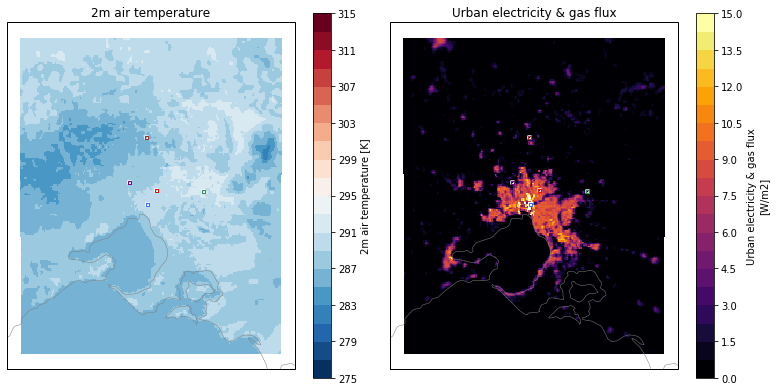

In [16]:
###############################################################################
##### URBAN TYPES 
###############################################################################

# data['urbant'].values = data['urbant'].values.astype(int)
# if suffix == '_lcz':
# 	data['urbant'] = data['urbant'] - 8
# data['urbant'].attrs['long_name'] = 'Urban type'

plotsites = ['melb','bundoora','coldstream','melb_air','kilmore']

# plot grid and urban fractions
plt.close('all')
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5.5),
    subplot_kw={'projection': ccrs.Robinson(central_longitude=lon_mid)})

# plot dataset variables in list dsvars
for k,dsvar in enumerate(dsvars):

    # cmap = cmaps[k]
    # camp = cmap.set_over('white')

    dsplot = data[dsvar].isel(time=1).plot(ax=axes[k], vmin=dsminv[k], vmax=dsmaxv[k],
        cmap=cmaps[k], transform=ccrs.PlateCarree(), # transform=ccrs.PlateCarree(), levels=21,
        extend=dsextend[k], cbar_kwargs={'ticks': dsticks[k]}, levels=dslevs[k] )

    if vtype=='type' and k==1:
        dsplot.cmap.set_over('white')

    
    axes[k].set_title(data[dsvar].long_name)
    axes[k].coastlines(color='0.5',lw=0.5,resolution='10m')

    fig, axes[k] = plot_sites(fig, axes[k],plotsites)

# draw grid res in centre: 
if vtype=='grid' and k==1:
    axes[0].scatter(x=lon_mid,y=lat_mid,s=9,marker='x',linewidth=0.5,color='k',transform=ccrs.PlateCarree())
    axes[0].text(x=lon_mid,y=lat_mid,s='center res.\n\n %.2f km' %mid_res, fontsize=6, va='center',ha='center',transform=ccrs.PlateCarree())



# draw canvas before tight_layout
fig.canvas.draw()
plt.tight_layout()

# fig.savefig('%s/grid_%s%s_%s.png' %(plotpath,res,suffix,vtype), dpi=200, bbox_inches='tight',pad_inches=0.05)
plt.show()

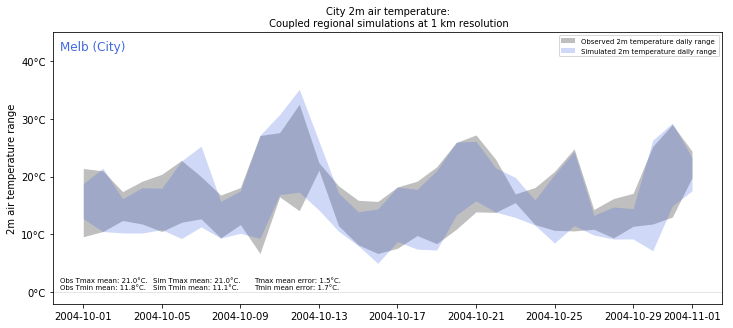

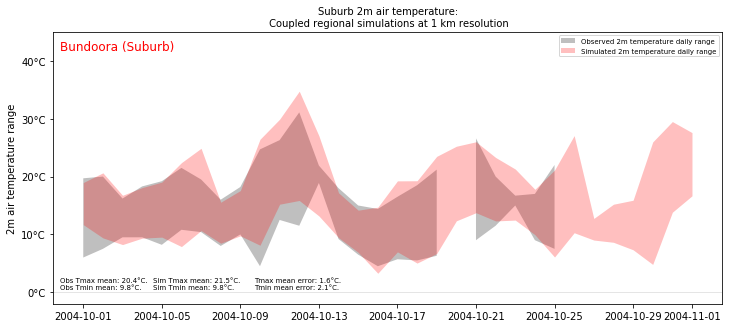

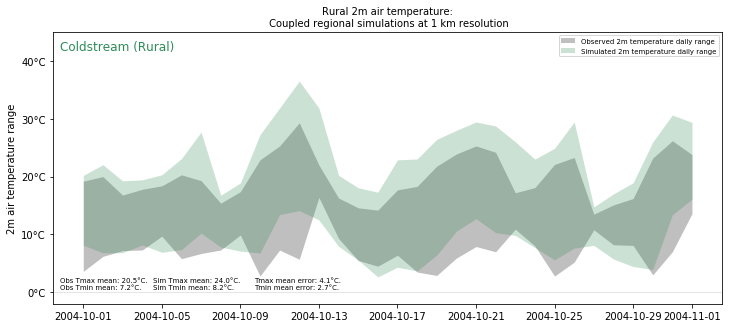

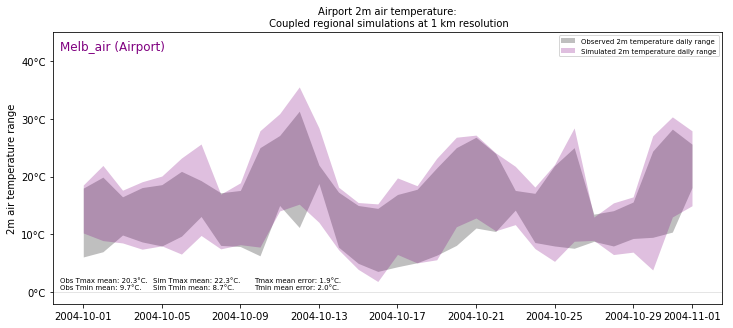

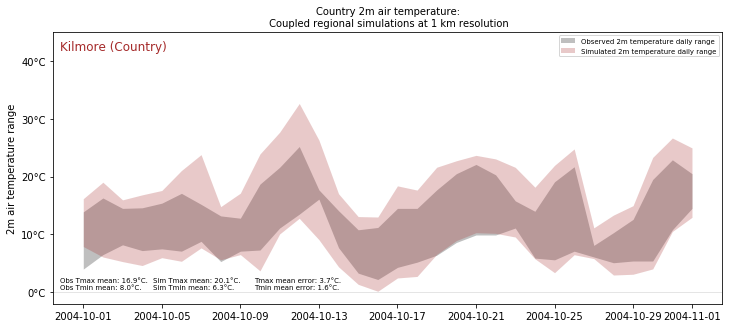

In [17]:
###############################################################################
##### Timeseries
###############################################################################

sim = {}

for site in plotsites:
    sim[site] = data[['tas','anth_elecgas_ave']].sel(lat=sinfo[site]['lat'],lon=sinfo[site]['lon'], 
        method='nearest').to_dataframe()[['tas','anth_elecgas_ave']]
    # convert to celcius
    sim[site]['tas'] = sim[site]['tas'] - 273.15


##########################################################
############    2m temp timeseries plots      ############
##########################################################

sdate = sim[site].index[0].date()
edate = sim[site].index[-2].date()
degtick = mtick.StrMethodFormatter('{x:,.0f}°C')

for site in plotsites:

    title = sinfo[site]['title']
    color = sinfo[site]['color']

    plt.close('all')
    fig,ax = plt.subplots(1,figsize=(12,5))
    ax.set_title('%s 2m air temperature:\n Coupled regional simulations at 1 km resolution' %title,fontsize=10)

    # min max
    ax.fill_between(bomstation[site][sdate:edate].index, 
                    bomstation[site][sdate:edate]['t2max'], bomstation[site][sdate:edate]['t2min'],
                    lw=0.0,alpha=0.25, color='Black', label='Observed 2m temperature daily range')
    ax.fill_between(sim[site].resample('1D').max().index,
                    sim[site]['tas'].resample('1D').min(), sim[site]['tas'].resample('1D').max(),
                    lw=0.0,alpha=0.25, color=color, label='Simulated 2m temperature daily range')

    ax.text(0.01,0.97,'%s (%s)' %(site.capitalize(),title),transform=ax.transAxes, ha='left',va='top',color=color, fontsize=12)

    ax.yaxis.set_major_formatter(degtick)
    ax.set_ylabel('2m air temperature range')
    # ax.set_xlim([pd.Timestamp(start)-pd.Timedelta(days=1),pd.Timestamp(end)+pd.Timedelta(hours=1)])
    ax.axhline(color='0.8',lw=0.5)
    ax.set_ylim([-2,45])

    ax.text(0.01,0.05, 'Obs Tmax mean: %.1f°C. \nObs Tmin mean: %.1f°C.'
        %(bomstation[site]['t2max'].mean(), bomstation[site]['t2min'].mean()),
        transform=ax.transAxes,ha='left',va='bottom', fontsize=7)

    ax.text(0.15,0.05, 'Sim Tmax mean: %.1f°C. \nSim Tmin mean: %.1f°C.'
        %(sim[site]['tas'].resample('1D').max().mean(), sim[site]['tas'].resample('1D').min().mean()),
        transform=ax.transAxes,ha='left',va='bottom', fontsize=7)

    ax.text(0.30,0.05, 'Tmax mean error: %.1f°C. \nTmin mean error: %.1f°C.'
        %( MAE( sim[site]['tas'].resample('1D').max(),bomstation[site]['t2max'] ), 
           MAE( sim[site]['tas'].resample('1D').min(),bomstation[site]['t2min'] )),
        transform=ax.transAxes,ha='left',va='bottom', fontsize=7)

    ax.legend(fontsize='x-small',loc='upper right',ncol=1)
    # fig.savefig('%s/2mtemps_%s.png' %(plotpath,site), dpi=200, bbox_inches='tight',pad_inches=0.05)
    plt.show()